<a href="https://colab.research.google.com/github/HRashmika/Bank_Prediction/blob/main/ML_CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [21]:

# File path
file_path = 'bank-additional-full.csv'
data_add = pd.read_csv(file_path, delimiter=';')

# Debugging: print the original data
print("Original DataFrame Shape:", data_add.shape)

# Step 1: Remove the 'duration' column
data_add = data_add.drop('duration', axis=1, errors='ignore')
data_add = data_add.drop(['default', 'pdays'], axis=1, errors='ignore')

# Compute percentage distribution for categorical columns
categorical_columns = ['housing', 'loan', 'poutcome', 'y']

print("\nPercentage Distribution of Categories:")
for col in categorical_columns:
    print(f"\nColumn: {col}")
    percentages = data_add[col].value_counts(normalize=True) * 100
    print(percentages)


# Step 2: One-hot encode categorical columns
one_hot_columns = ['job', 'marital', 'education', 'housing', 'loan',
                   'contact', 'month', 'day_of_week']
data_add = pd.get_dummies(data_add, columns=one_hot_columns, drop_first=True)

# Step 3: Label encode 'poutcome' column
label_columns = ['poutcome']
label_encoder = LabelEncoder()
label_mappings = {}

for col in label_columns:
    data_add[col] = label_encoder.fit_transform(data_add[col].fillna('unknown'))  # Fill NaNs with 'unknown'
    label_mappings[col] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Encode target column 'y'
data_add['y'] = data_add['y'].map({'yes': 1, 'no': 0})

# Print label mappings
print("\nLabel Mappings for 'poutcome':", label_mappings)

# Step 4: Handle duplicates
duplicates = data_add.duplicated().sum()
if duplicates > 0:
    print(f"\n{duplicates} duplicate rows found and removed.")
    data_add = data_add.drop_duplicates()
else:
    print("\nNo duplicate rows found.")

# Step 5: Handle missing values
missing_values = data_add.isnull().sum()
if missing_values.any():
    print("\nMissing Values Found:")
    print(missing_values[missing_values > 0])
    for col in data_add.columns:
        if data_add[col].dtype == 'object':
            data_add[col].fillna('unknown', inplace=True)
        else:
            data_add[col].fillna(data_add[col].median(), inplace=True)
else:
    print("\nNo missing values found.")

# Step 6: Min-Max Normalization
scaler = MinMaxScaler()
features_to_scale = data_add.drop('y', axis=1)
data_add[features_to_scale.columns] = scaler.fit_transform(features_to_scale)

# Step 7: Split data into features (X) and target (y)
X = data_add.drop('y', axis=1)
y = data_add['y']

# Step 8: Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 9: Balance the training dataset using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)


# Combine balanced data for inspection
train_data_add = pd.DataFrame(X_train_balanced, columns=X.columns)
train_data_add['y'] = y_train_balanced

test_data_add = X_test.copy()
test_data_add['y'] = y_test

# Print dataset shapes and class distributions
print("\nTraining Data Shape (After Balancing):", train_data_add.shape)
print("Testing Data Shape:", test_data_add.shape)
print("\nClass Distribution in Balanced Training Data:")
print(train_data_add['y'].value_counts(normalize=True))

# Final DataFrame Info
print("\nFinal DataFrame Info:")
data_add.info()
print("\nFinal DataFrame Preview:")
print(data_add.head())

# Check class distribution in the target variable ('y')
class_distribution = data_add['y'].value_counts(normalize=True) * 100
print("Class Distribution (%):")
print(class_distribution)



Original DataFrame Shape: (41188, 21)

Percentage Distribution of Categories:

Column: housing
housing
yes        52.384190
no         45.212198
unknown     2.403613
Name: proportion, dtype: float64

Column: loan
loan
no         82.426920
yes        15.169467
unknown     2.403613
Name: proportion, dtype: float64

Column: poutcome
poutcome
nonexistent    86.343110
failure        10.323395
success         3.333495
Name: proportion, dtype: float64

Column: y
y
no     88.734583
yes    11.265417
Name: proportion, dtype: float64

Label Mappings for 'poutcome': {'poutcome': {'failure': 0, 'nonexistent': 1, 'success': 2}}

2008 duplicate rows found and removed.

No missing values found.

Training Data Shape (After Balancing): (55342, 49)
Testing Data Shape: (7836, 49)

Class Distribution in Balanced Training Data:
y
0    0.5
1    0.5
Name: proportion, dtype: float64

Final DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 39180 entries, 0 to 41187
Data columns (total 49 columns):
 #

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [22]:
from google.colab import drive
drive.mount('/content/drive')

# Set output directory in Google Drive
output_dir = '/content/drive/My Drive/ML_CW/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Define file paths
transformed_path = os.path.join(output_dir, 'transformed_add.csv')
train_data_path = os.path.join(output_dir, 'train_data_add.csv')
test_data_path = os.path.join(output_dir, 'test_data_add.csv')

try:
    # Save datasets
    data_add.to_csv(transformed_path, index=False)
    train_data_add.to_csv(train_data_path, index=False)
    test_data_add.to_csv(test_data_path, index=False)

    # Confirm saved files
    if os.path.exists(transformed_path):
        print(f"Transformed data saved to: {transformed_path}")
    else:
        print("Error: Transformed data not saved.")

    if os.path.exists(train_data_path):
        print(f"Training data saved to: {train_data_path}")
    else:
        print("Error: Training data not saved.")

    if os.path.exists(test_data_path):
        print(f"Testing data saved to: {test_data_path}")
    else:
        print("Error: Testing data not saved.")
except Exception as e:
    print(f"Error while saving files: {e}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Transformed data saved to: /content/drive/My Drive/ML_CW/transformed_add.csv
Training data saved to: /content/drive/My Drive/ML_CW/train_data_add.csv
Testing data saved to: /content/drive/My Drive/ML_CW/test_data_add.csv


Accuracy: 0.88

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      6918
           1       0.46      0.36      0.40       918

    accuracy                           0.88      7836
   macro avg       0.69      0.65      0.67      7836
weighted avg       0.86      0.88      0.87      7836


Confusion Matrix:
[[6531  387]
 [ 587  331]]

Top Features:
       Feature  Importance
7    euribor3m    0.141041
1     campaign    0.121567
0          age    0.088582
8  nr.employed    0.070435
3     poutcome    0.054090


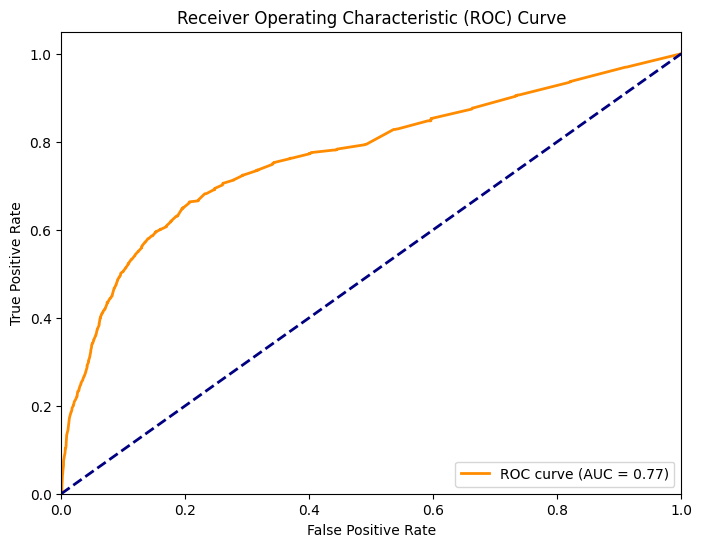


AUC: 0.7677


In [25]:
# File paths for training and testing data
train_file_path = '/content/drive/My Drive/ML_CW/train_data_add.csv'
test_file_path = '/content/drive/My Drive/ML_CW/test_data_add.csv'

# Load training and testing data
train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

X_train = train_data.drop('y', axis=1)
y_train = train_data['y']
X_test = test_data.drop('y', axis=1)
y_test = test_data['y']

# Initialize Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the classifier
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Feature Importances
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_classifier.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop Features:")
print(feature_importances.head())

# Predict probabilities on the test set (for ROC curve)
y_prob = rf_classifier.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print the AUC value
print(f"\nAUC: {roc_auc:.4f}")


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1384/1384 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7166 - loss: 0.5728 - val_accuracy: 0.5565 - val_loss: 0.7637
Epoch 2/30
1384/1384 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7648 - loss: 0.5224 - val_accuracy: 0.5658 - val_loss: 0.7501
Epoch 3/30
1384/1384 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7763 - loss: 0.5019 - val_accuracy: 0.5744 - val_loss: 0.7511
Epoch 4/30
1384/1384 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7801 - loss: 0.4900 - val_accuracy: 0.6006 - val_loss: 0.6521
Epoch 5/30
1384/1384 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7842 - loss: 0.4847 - val_accuracy: 0.6007 - val_loss: 0.6707
Epoch 6/30
1384/1384 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7884 - loss: 0.4760 - val_accuracy: 0.6160 - val_loss: 0.6327
Epoch 7/30
1384/1384 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7927 - loss: 0.4714 - val_accuracy: 0.6128 - val_loss: 0.6512
Epoch 8/30
1384/1384 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7901 - loss: 0.4660 - val_accurac

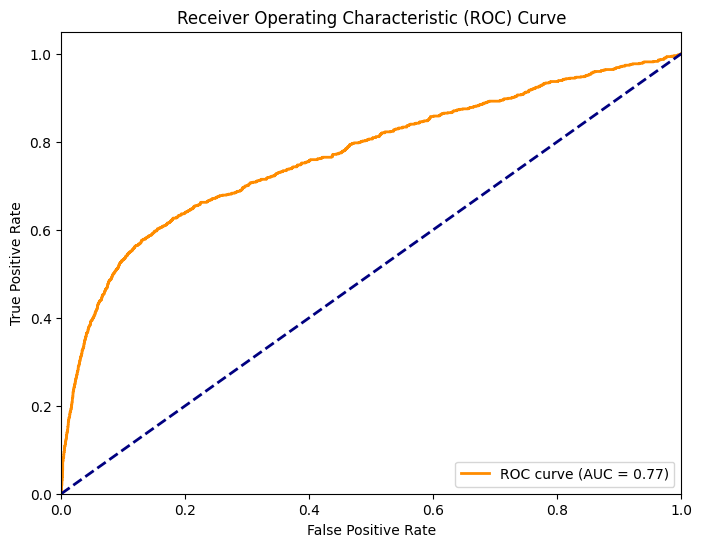


AUC: 0.7689


In [24]:

# Define file paths in Google Drive
train_data_path = '/content/drive/My Drive/ML_CW/train_data_add.csv'
test_data_path = '/content/drive/My Drive/ML_CW/test_data_add.csv'

# Load the datasets
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

# Split features (X) and target (y)
X_train = train_data.drop('y', axis=1)
y_train = train_data['y']
X_test = test_data.drop('y', axis=1)
y_test = test_data['y']

# Build the Neural Network model
model = Sequential([
    Dense(64, activation='relu', input_dim=X_train.shape[1]),  # Input layer
    Dropout(0.3),  # Regularization
    Dense(32, activation='relu'),  # Hidden layer
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

y_pred = (model.predict(X_test) > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Predict probabilities on the test set
y_prob = model.predict(X_test)

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print the AUC value
print(f"\nAUC: {roc_auc:.4f}")